In [30]:

import pandas as pd
import numpy as np
import plotly as px
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
    
    
df = pd.read_csv('C:\\data.txt')
df['Date'] = pd.to_datetime(df['Date'])
df['weekly_sales'] = df['Price'] * df['Weekly_Units_Sold']
df.set_index('Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear


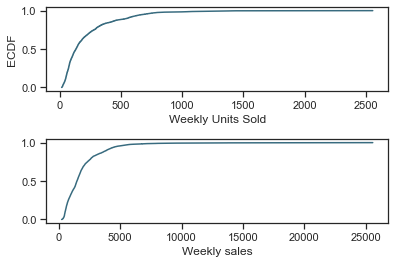

In [31]:

sns.set(style = "ticks")
c = '#386B7F' 
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=2.0)
plt.subplot(211)
cdf = ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Weekly Units Sold'); plt.ylabel('ECDF');

plt.subplot(212)
cdf = ECDF(df['weekly_sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Weekly sales');


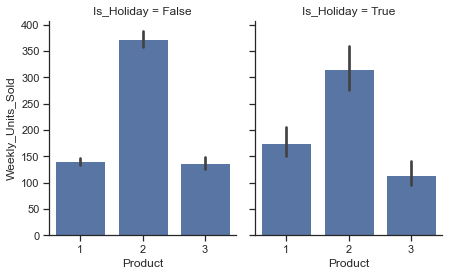

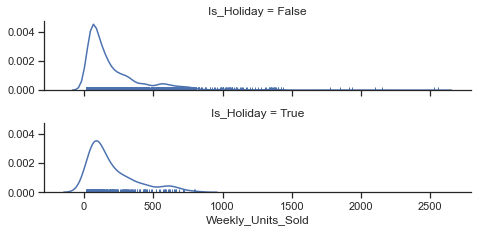

In [32]:
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8)
g.map(sns.barplot, "Product", "Weekly_Units_Sold");

 

g = sns.FacetGrid(df, row="Is_Holiday",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True);



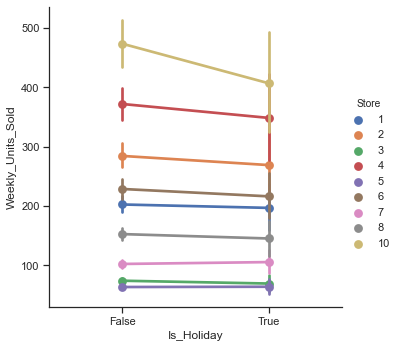

In [35]:
sns.factorplot(data= df, 
               x= 'Is_Holiday',
               y= 'Weekly_Units_Sold',
               hue= 'Store');




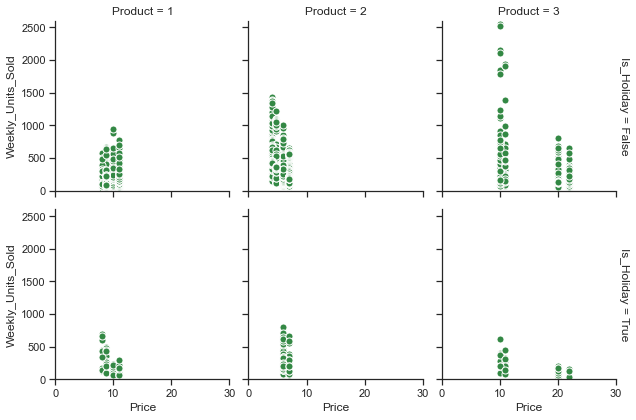

In [34]:


g = sns.FacetGrid(df, col="Product", row="Is_Holiday", margin_titles=True, height=3)
g.map(plt.scatter, "Price", "Weekly_Units_Sold", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 30), ylim=(0, 2600));


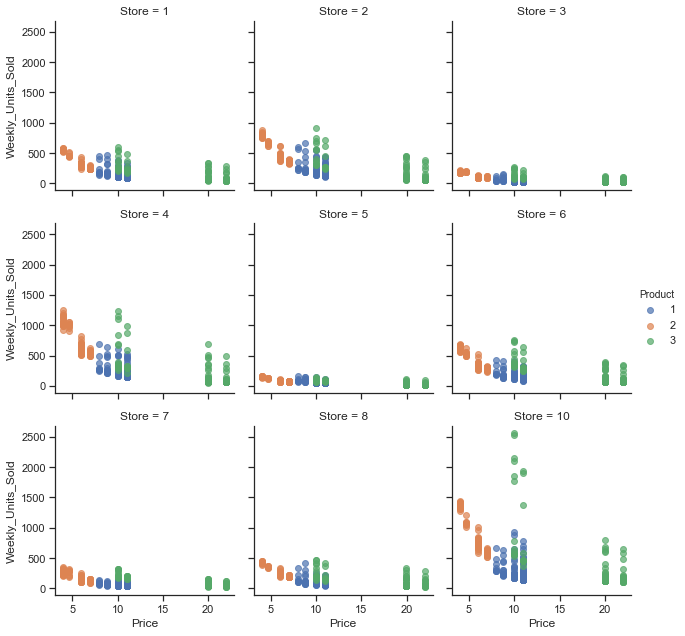

In [36]:

g = sns.FacetGrid(df, col="Store", hue="Product", margin_titles=True, col_wrap=3)
g.map(plt.scatter, 'Price', 'Weekly_Units_Sold', alpha=.7)
g.add_legend();



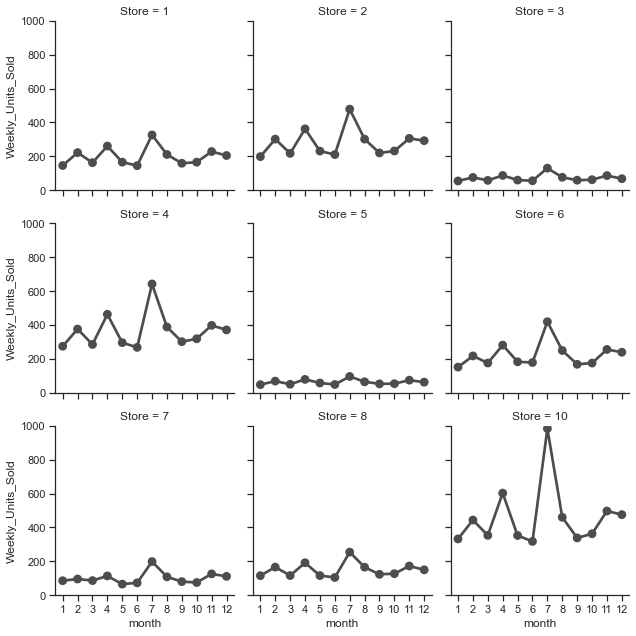

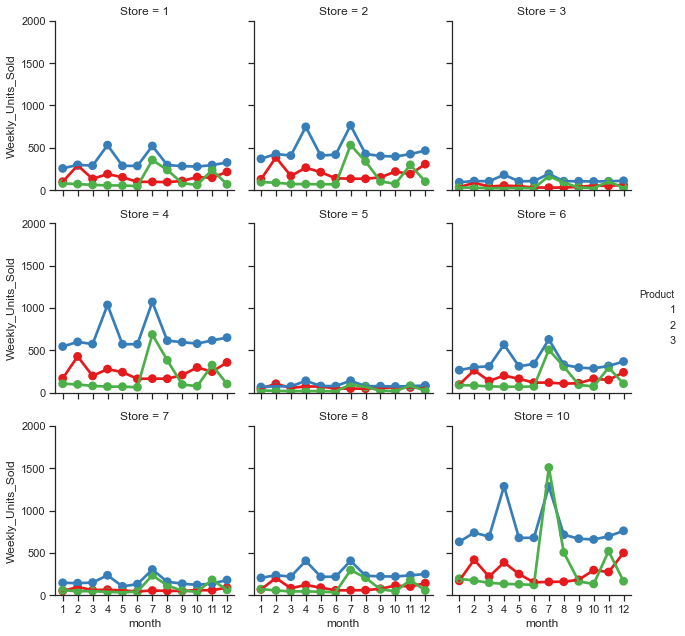

In [37]:

g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 1000))
g.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12]);

 

g = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 2000), hue='Product', palette="Set1")
g.map(sns.pointplot, "month", "Weekly_Units_Sold", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12], alpha=.7)
g.add_legend();



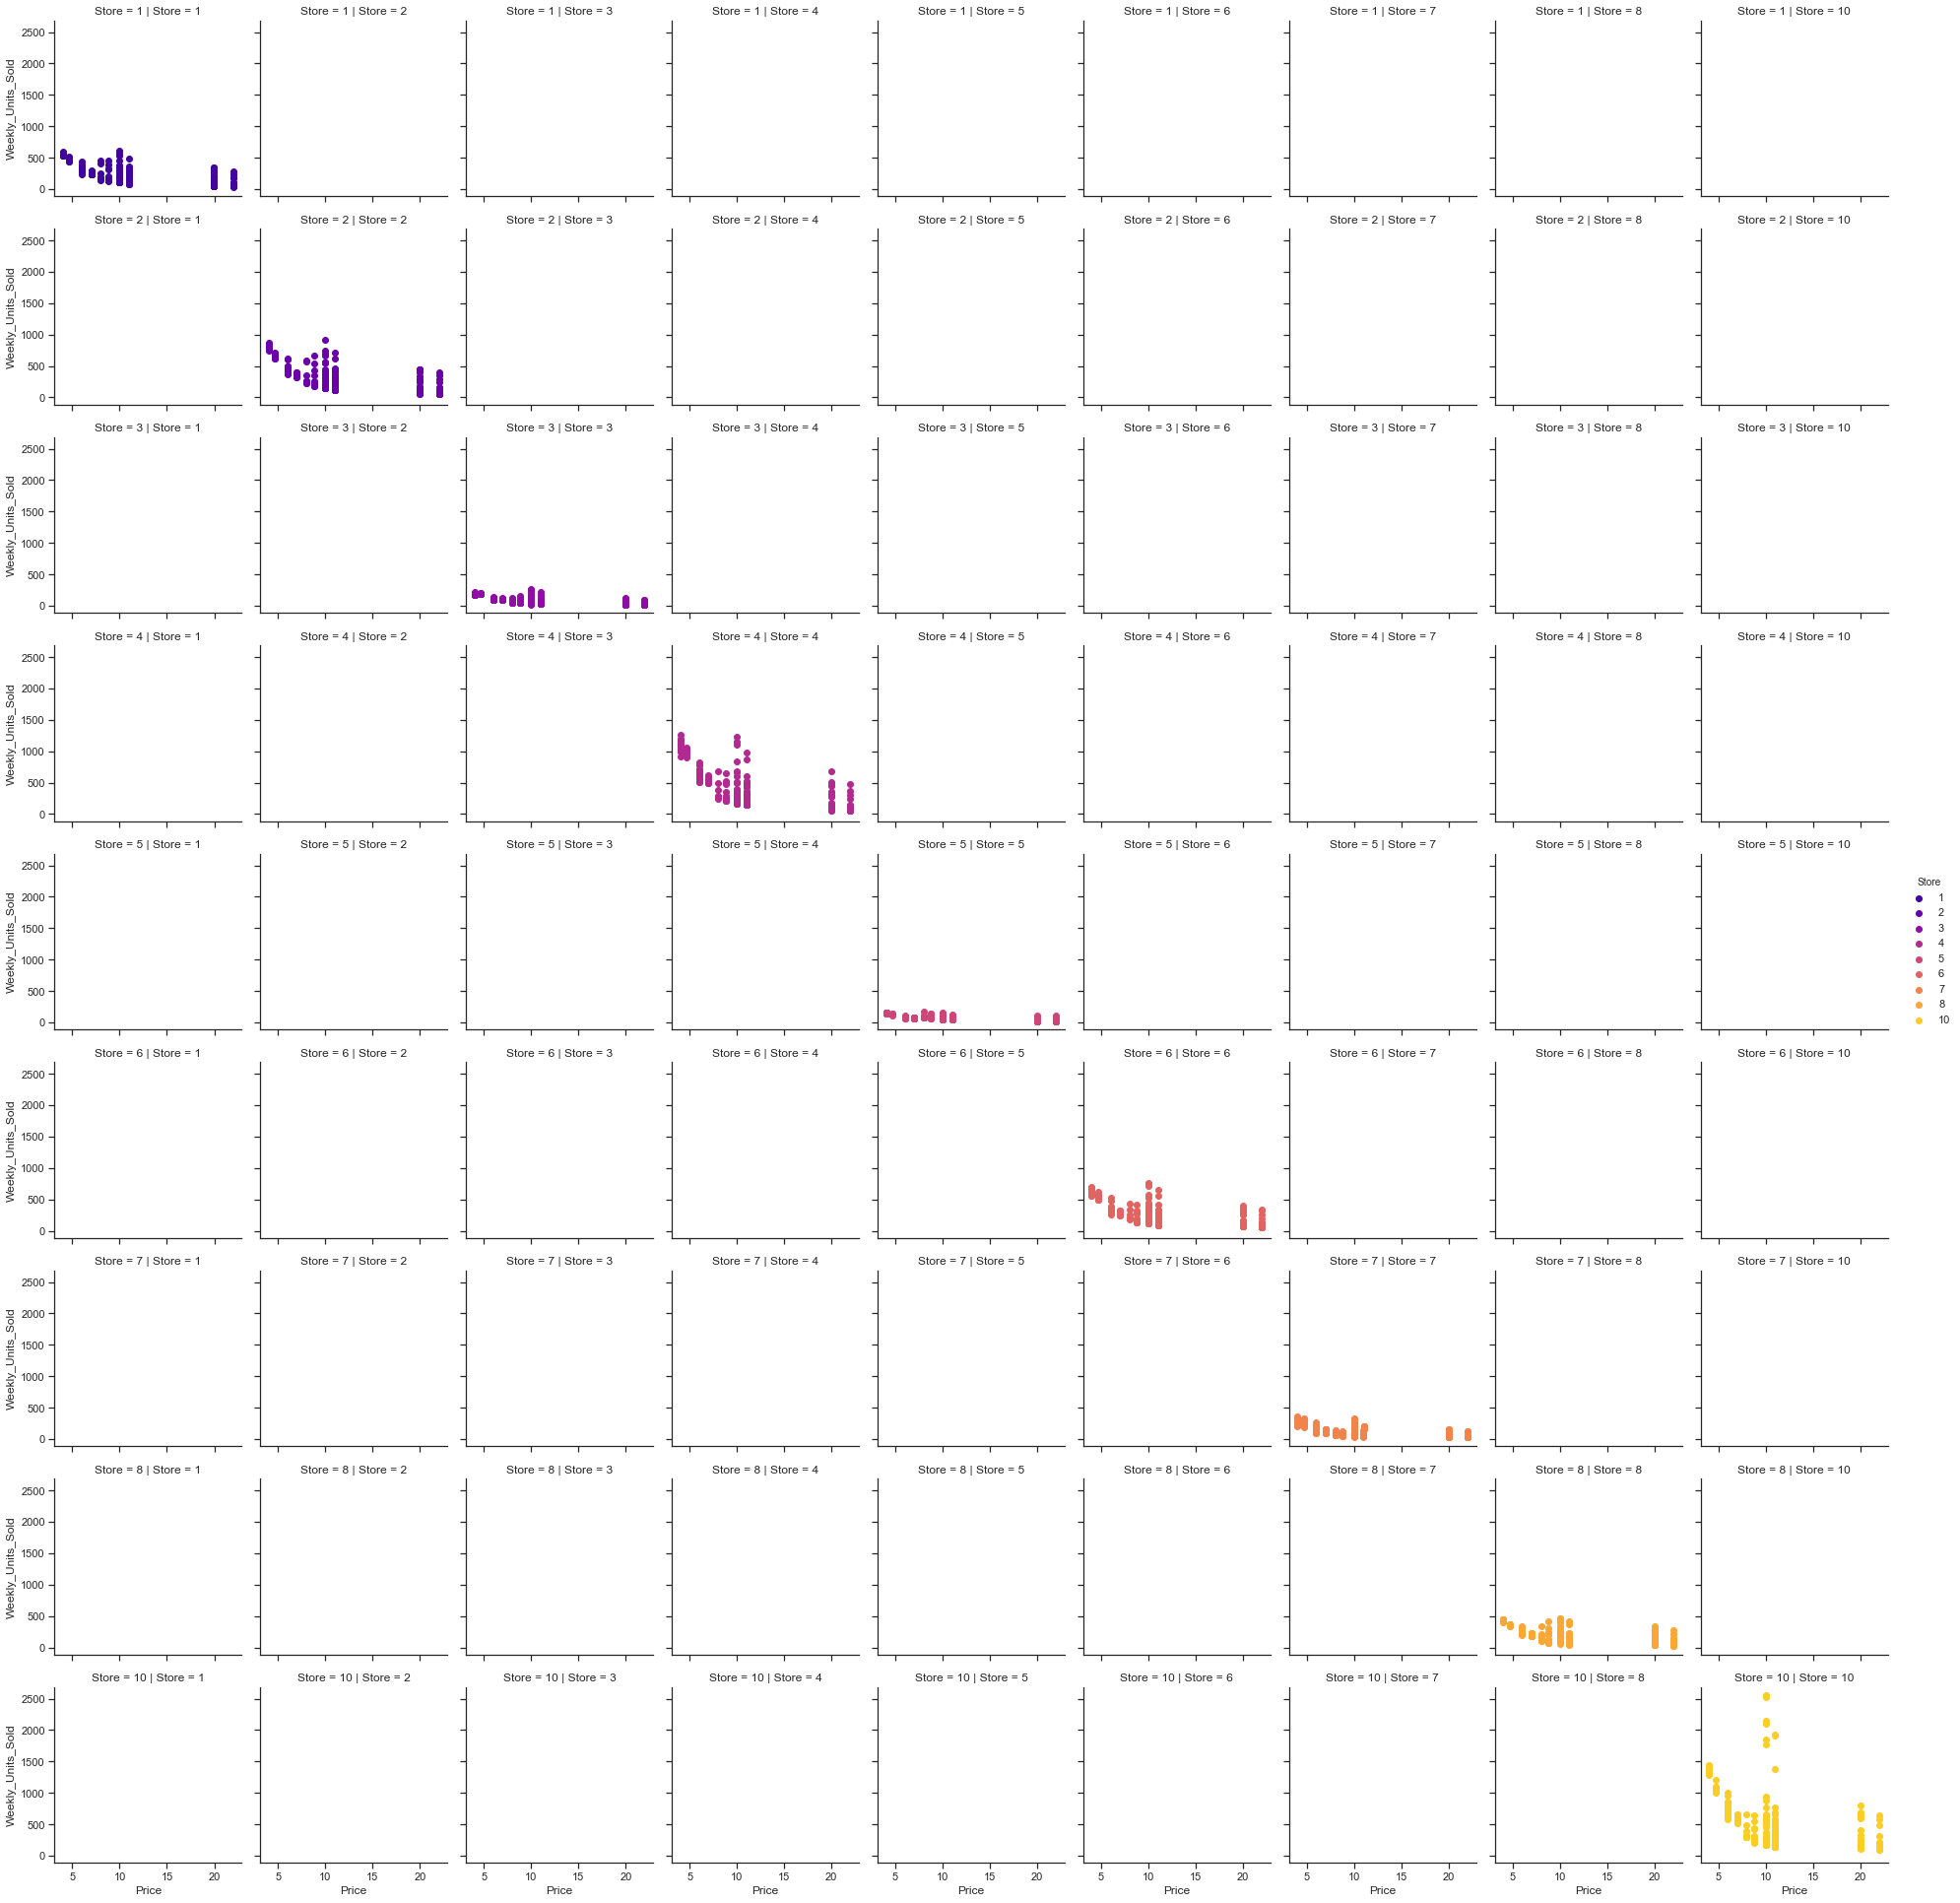

In [38]:

g = sns.FacetGrid(df, col="Store", hue="Store", palette = 'plasma', row='Store')
g = (g.map(plt.scatter, "Price", "Weekly_Units_Sold").add_legend())



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


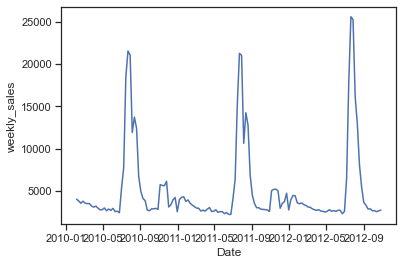

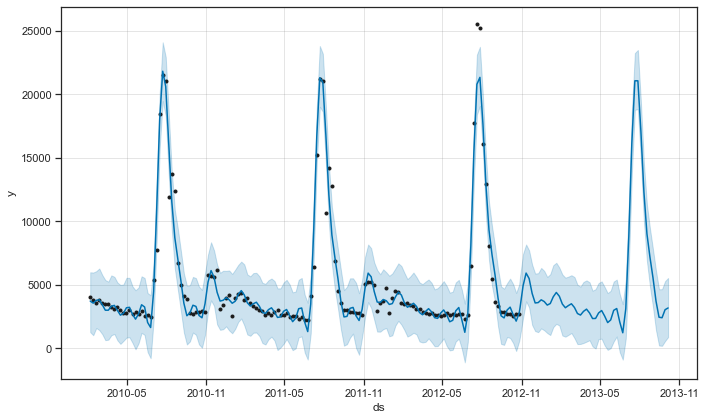

In [42]:
store_10_pro_3 = df[(df.Store == 10) & (df.Product == 3)].loc[:, ['Base Price', 'Price', 'Weekly_Units_Sold', 'weekly_sales']]
store_10_pro_3.reset_index(level=0, inplace=True)
ax = sns.lineplot(x="Date", y="weekly_sales", data=store_10_pro_3)

 

store_10_pro_3 = store_10_pro_3[['Date', 'weekly_sales']].rename(columns = {'Date': 'ds','weekly_sales': 'y'})
 
model = Prophet(interval_width = 0.95)
model.fit(store_10_pro_3) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)
model.plot(forecast);


In [43]:

metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))



The RMSE is 1190.0956338021556


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 720x360 with 0 Axes>

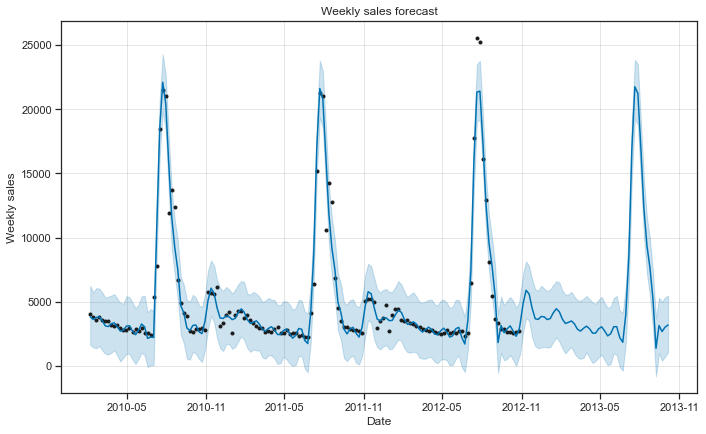

In [44]:
def is_school_holiday_season(ds):    
    date = pd.to_datetime(ds)
    starts = datetime.date(date.year, 7, 1)
    ends = datetime.date(date.year, 9, 9)
    return starts < date.to_pydatetime().date() < ends

store_10_pro_3['school_holiday_season'] = store_10_pro_3['ds'].apply(is_school_holiday_season)
store_10_pro_3['not_school_holiday_season'] = ~store_10_pro_3['ds'].apply(is_school_holiday_season)
model = Prophet(interval_width=0.95)

model.add_seasonality(name='school_holiday_season', period=365, fourier_order=3, condition_name='school_holiday_season')
model.add_seasonality(name='not_school_holiday_season', period=365, fourier_order=3, condition_name='not_school_holiday_season')
model.fit(store_10_pro_3)

forecast = model.make_future_dataframe(periods=50, freq='W')
forecast['school_holiday_season'] = forecast['ds'].apply(is_school_holiday_season)
forecast['not_school_holiday_season'] = ~forecast['ds'].apply(is_school_holiday_season)
forecast = model.predict(forecast)

plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'Weekly sales')
plt.title('Weekly sales forecast');


In [45]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))


The RMSE is 1127.1252945470821


In [ ]:

# data:
# https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/Sales_Product_Price_by_Store.csv
